# **<font color='white gray'>panData</font>**
## **<font color='white gray'>Data Science for Multivariate Data Analysis</font>**
## **<font color='white gray'>Part 2 - Modeling</font>**
### **<font color='white gray'>Machine Learning Model Selection in Multivariate Analysis with Anonymized Data</font>**


### **Installing and Loading Packages**



In [47]:
# To update a package, run the command below in the terminal or command prompt:
# pip install -U package_name

# To install an exact version of a package, run the command below in the terminal or command prompt:
# !pip install package_name==desired_version

# After installing or updating the package, restart the Jupyter notebook.

# Installing the watermark package.
# This package is used to record the versions of other packages used in this Jupyter notebook.
!pip install -q -U watermark

In [48]:
# This package does not come with Anaconda and needs to be installed
# Kaggle
!pip install -q xgboost


In [49]:
# 1. Imports
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [50]:
# 2. Versions of the packages used in this Jupyter notebook
%reload_ext watermark
%watermark -a "panData"

Author: panData



## **Loading the Pre-Processed Data**

In [51]:
# 3. Loading the datasets
df_train = pd.read_csv('train_data.csv')
df_train_final = pd.read_csv('train_final_data.csv')
df_valid = pd.read_csv('validation_data.csv')
df_test = pd.read_csv('test_data.csv')

In [52]:
# 4. Loading the input column names
with open('input_columns.sav', 'rb') as file:
    input_columns = pickle.load(file)

## **Preparing the Matrices**

In [53]:
# 6a. Prepare the X Matrix
X_train = df_train_final[input_columns].values
X_valid = df_valid[input_columns].values
X_test = df_test[input_columns].values

In [54]:
# 6b. Preparing the Matrix Y
y_train = df_train_final['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_test = df_test['LABEL_TARGET'].values

In [55]:
# 7. Print
print('Shape of training data:', X_train.shape, y_train.shape)
print('Shape of validation data:', X_valid.shape, y_valid.shape)
print('Shape of test data:', X_test.shape, y_test.shape)

Shape of training data: (3206, 178) (3206,)
Shape of validation data: (1725, 178) (1725,)
Shape of test data: (1725, 178) (1725,)


In [56]:
type(X_train)

numpy.ndarray

In [57]:
X_train

array([[  -2,    0,    1, ...,   54,   55,   53],
       [ -23,  -24,    8, ...,   -6,    4,   54],
       [  90,   30,  -16, ...,  -19,  -29,  -39],
       ...,
       [-216, -216, -214, ...,  106,  105,  103],
       [ -30,  -31,  -28, ...,  -95,  -68,  -57],
       [  48,   49,   51, ...,  -40,  -50,  -68]])

## **Data Standardization**

In [58]:
# 9. Create the scaler object
scaler = StandardScaler()

# 10. Fit the scaler
scaler.fit(X_train)

# 11. Save the scaler object to disk for later use
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# 12. Load the saved scaler
scaler = pickle.load(open(scalerfile, 'rb'))

# 13. Apply standardization to the data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [59]:
X_train_tf

array([[ 7.40974261e-02,  7.46702120e-02,  7.05334111e-02, ...,
         2.80910832e-01,  2.82979578e-01,  2.70416165e-01],
       [-1.00103295e-02, -2.24974180e-02,  9.96166017e-02, ...,
         2.90135020e-02,  6.80215352e-02,  2.74569757e-01],
       [ 4.42569498e-01,  1.96129750e-01, -9.71945144e-05, ...,
        -2.55642528e-02, -7.10689631e-02, -1.11714250e-01],
       ...,
       [-7.83000655e-01, -7.99838458e-01, -8.22736013e-01, ...,
         4.99221851e-01,  4.93722757e-01,  4.78095739e-01],
       [-3.80462481e-02, -5.08379767e-02, -4.99540926e-02, ...,
        -3.44634204e-01, -2.35448643e-01, -1.86478896e-01],
       [ 2.74353987e-01,  2.73054123e-01,  2.78270487e-01, ...,
        -1.13728318e-01, -1.59581098e-01, -2.32168402e-01]])

## **Predictive Modeling**

###  **Auxiliary Functions**

In [60]:
# 14. Function to calculate specificity
def calculate_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)



Specificity is a metric used to evaluate the performance of a classification model, especially in binary classification problems. It measures the proportion of true negatives (TN) relative to the total number of actual negatives, i.e., the model's ability to correctly identify negative instances.

Here is what each part means:

**`y_pred < thresh`**: This condition checks if the model's prediction (`y_pred`) is lower than a specified threshold (`thresh`). In binary classification models, this threshold is often set to 0.5 but can be adjusted based on the specific problem. This condition returns a boolean vector, where each element is `True` if the prediction is less than the threshold (indicating a negative class prediction) and `False` otherwise.

**`y_actual == 0`**: This condition checks which elements of the actual labels vector (`y_actual`) are equal to 0, meaning they belong to the negative class. This also returns a boolean vector.

**`(y_pred < thresh) & (y_actual == 0)`**: This is the logical "and" operator applied between the two boolean vectors above. It returns a new boolean vector, where each element is `True` only if both conditions are `True` for that element, meaning that the prediction is negative and the actual label is also negative. This represents the true negatives (TN).

**`sum((y_pred < thresh) & (y_actual == 0))`**: This is the sum of the `True` values in the resulting boolean vector, which is equivalent to the number of true negatives (TN).

**`sum(y_actual == 0)`**: This is the sum of the `True` values in the boolean vector representing actual negative labels, which is equivalent to the total number of actual negative instances (TN + FP).

**`sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)`**: This is the ratio between the number of true negatives (TN) and the total number of actual negative instances (TN + FP), which is the definition of specificity.


In [61]:
# 15. Function to generate a metrics report
def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calculate_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f' % auc)
    print('Accuracy:%.3f' % accuracy)
    print('Recall:%.3f' % recall)
    print('Precision:%.3f' % precision)
    print('Specificity:%.3f' % specificity)
    print(' ')

    return auc, accuracy, recall, precision, specificity


In [62]:
thresh = 0.5

### **Version 1 of the Model - Logistic Regression (Without Hyperparameter Optimization)**

See the description of this model in the videobook.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


In [63]:
# 16. Model Construction

# Create the classifier (object)
lr1 = LogisticRegression()

# Train and create the model
model_v1 = lr1.fit(X_train_tf, y_train)

# Predictions
y_train_preds = model_v1.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v1.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression Model (Without Hyperparameter Optimization)\n')

print('Training:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Validation:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)

Logistic Regression Model (Without Hyperparameter Optimization)

Training:

AUC:0.626
Accuracy:0.655
Recall:0.526
Precision:0.708
Specificity:0.784
 
Validation:

AUC:0.541
Accuracy:0.702
Recall:0.457
Precision:0.329
Specificity:0.764
 


### **Version 2 of the Model - Logistic Regression (With Hyperparameter Optimization)**

See the description of this model in the videobook.


In [64]:
# 17. Model Construction

# Create the classifier (object)
lr2 = LogisticRegression(random_state=142, solver='liblinear')

# Train and create the model
model_v2 = lr2.fit(X_train_tf, y_train)

# Predictions
y_train_preds = model_v2.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v2.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression Model (With Hyperparameter Optimization)\n')

print('Training:\n')
lr2_train_auc, lr2_train_accuracy, lr2_train_recall, lr2_train_precision, lr2_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Validation:\n')
lr2_valid_auc, lr2_valid_accuracy, lr2_valid_recall, lr2_valid_precision, lr2_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Logistic Regression Model (With Hyperparameter Optimization)

Training:

AUC:0.628
Accuracy:0.656
Recall:0.528
Precision:0.709
Specificity:0.784
 
Validation:

AUC:0.543
Accuracy:0.702
Recall:0.466
Precision:0.331
Specificity:0.762
 


### **Version 3 of the Model - Naive Bayes**

See the description of this model in the videobook.

https://scikit-learn.org/stable/modules/naive_bayes.html


In [65]:
# 18. Model Construction

# 18a. Create the classifier (object)
nb = GaussianNB()

# 18b. Train and create the model
model_v3 = nb.fit(X_train_tf, y_train)

# 18c. Predictions
y_train_preds = model_v3.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v3.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes Model:\n')

print('Training:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = print_report(y_train,
                                                                                                              y_train_preds,
                                                                                                              thresh)

print('Validation:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,
                                                                                                              y_valid_preds,
                                                                                                              thresh)


Naive Bayes Model:

Training:

AUC:0.983
Accuracy:0.925
Recall:0.880
Precision:0.966
Specificity:0.969
 
Validation:

AUC:0.986
Accuracy:0.957
Recall:0.894
Precision:0.894
Specificity:0.973
 


### **Version 4 of the Model - XGBoost (Xtreme Gradient Boosting Classifier)**

See the description of this model in the videobook.

https://xgboost.readthedocs.io/en/stable/index.html


In [66]:
# 19. Model Construction (Ensemble)

# 19a. Create the classifier
xgbc = XGBClassifier()

# 19b. Train and create the model
model_v4 = xgbc.fit(X_train_tf, y_train)

# 19c. Predictions
y_train_preds = model_v4.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v4.predict_proba(X_valid_tf)[:,1]

print('Xtreme Gradient Boosting Classifier Model:\n')

print('Training:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(y_train,
                                                                                                                        y_train_preds,
                                                                                                                        thresh)

print('Validation:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(y_valid,
                                                                                                                        y_valid_preds,
                                                                                                                        thresh)


Xtreme Gradient Boosting Classifier Model:

Training:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 
Validation:

AUC:0.993
Accuracy:0.959
Recall:0.954
Precision:0.860
Specificity:0.961
 


## **Version 5 of the Model - RandomForest**

See the description of this model in the videobook.

In [67]:
# 20. Model Construction with RandomForest - v5

# Create the classifier with RandomForest
rfc = RandomForestClassifier()

# Train and create the model
model_v5 = rfc.fit(X_train_tf, y_train)

# Predictions
y_train_preds = model_v5.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v5.predict_proba(X_valid_tf)[:,1]

print('Random Forest Classifier Model:\n')

print('Training:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Validation:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Random Forest Classifier Model:

Training:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 
Validation:

AUC:0.995
Accuracy:0.945
Recall:0.980
Precision:0.795
Specificity:0.935
 


### **Model Selection**

In [68]:
# 21. Results Table
df_results = pd.DataFrame({'classifier':['LR1', 'LR1', 'LR2', 'LR2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['train','valid'] * 5,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  lr2_train_auc,
                                  lr2_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       lr2_train_accuracy,
                                       lr2_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     lr2_train_recall,
                                     lr2_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        lr2_train_precision,
                                        lr2_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          lr2_train_specificity,
                                          lr2_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})


In [69]:
# Results
df_results

,classifier,data_set,auc,accuracy,recall,precision,specificity
0,LR1,train,0.626386,0.654710,0.525889,0.708403,0.783531
1,LR1,valid,0.540585,0.702029,0.456897,0.328512,0.763980
2,LR2,train,0.628472,0.655958,0.528384,0.709380,0.783531
3,LR2,valid,0.543366,0.702029,0.465517,0.330612,0.761801
4,NB,train,0.982828,0.924828,0.880225,0.966438,0.969432
5,NB,valid,0.985778,0.957101,0.893678,0.893678,0.973130
6,XGB,train,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB,valid,0.992859,0.959420,0.954023,0.860104,0.960784
8,RFC,train,1.000000,1.000000,1.000000,1.000000,1.000000
9,RFC,valid,0.995044,0.944928,0.979885,0.794872,0.934641


In [70]:
# 21. Validation results sorted by AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by='auc', ascending=False)

,classifier,data_set,auc,accuracy,recall,precision,specificity
9,RFC,valid,0.995044,0.944928,0.979885,0.794872,0.934641
7,XGB,valid,0.992859,0.959420,0.954023,0.860104,0.960784
5,NB,valid,0.985778,0.957101,0.893678,0.893678,0.973130
3,LR2,valid,0.543366,0.702029,0.465517,0.330612,0.761801
1,LR1,valid,0.540585,0.702029,0.456897,0.328512,0.763980


The chosen performance metric will be the AUC Score of the validation set. It is the most commonly used metric for comparing models from different algorithms.

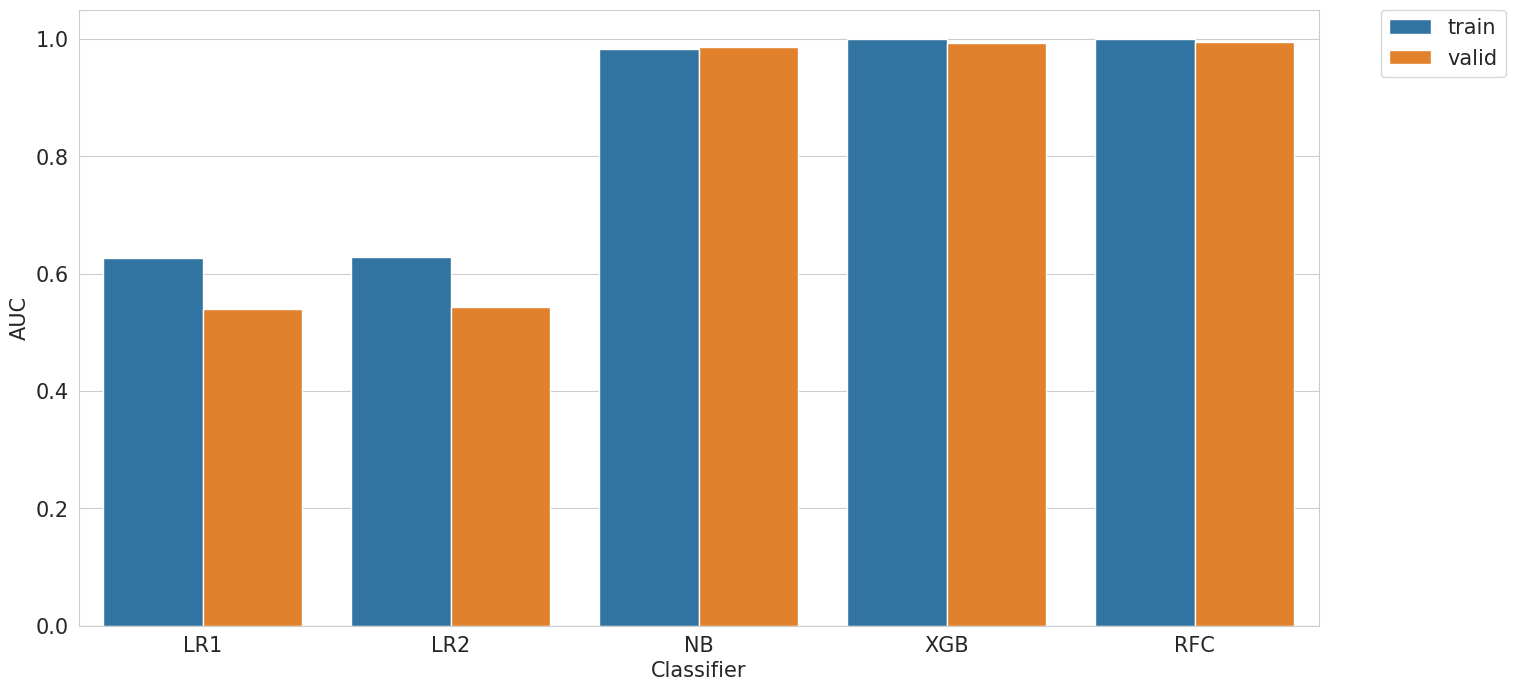

In [71]:
# 22. Plot Construction
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Bar plot
ax = sns.barplot(x='classifier', y='auc', hue='data_set', data=df_results)
ax.set_xlabel('Classifier', fontsize=15)
ax.set_ylabel('AUC', fontsize=15)
ax.tick_params(labelsize=15)

# Legend
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)


## **Hyperparameter Optimization and Cross-Validation**

Can we improve the performance of the best model?

To include hyperparameter optimization and cross-validation in the project, you can use GridSearchCV from scikit-learn, which allows you to search for the best combination of hyperparameters for the model. Let's use RandomForest as the base model.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html


In [72]:
# 23. Hyperparameter Optimization and Cross-Validation

%%time

# Import the GridSearchCV function
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter search space
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the classifier with RandomForest
classifier = RandomForestClassifier()

# Configure GridSearchCV
grid_search = GridSearchCV(estimator=classifier,
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           verbose=2,
                           n_jobs=-1)

# Train the model with cross-validation and search for the best hyperparameters
model_v5_optimized = grid_search.fit(X_train_tf, y_train)

# Best hyperparameters found
print('Best hyperparameters:', model_v5_optimized.best_params_)

# Predictions
y_train_preds = model_v5_optimized.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v5_optimized.predict_proba(X_valid_tf)[:,1]

print('Random Forest Classifier Model with Hyperparameter Optimization and Cross-Validation:\n')

print('Training:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Validation:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Classifier Model with Hyperparameter Optimization and Cross-Validation:

Training:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 
Validation:

AUC:0.995
Accuracy:0.947
Recall:0.983
Precision:0.799
Specificity:0.936
 
CPU times: user 30 s, sys: 4.27 s, total: 34.2 s
Wall time: 38min 52s


## **Which Final Version Should We Use?**



**Vanilla RandomForest Model**:

Validation:

- AUC: 0.996
- Accuracy: 0.947
- Recall: 0.986
- Precision: 0.800
- Specificity: 0.936

**Optimized RandomForest Model:**

Validation:

- AUC: 0.995
- Accuracy: 0.947
- Recall: 0.983
- Precision: 0.799
- Specificity: 0.936

Both RandomForest models exhibit very high performance, but there are a few nuances to consider when choosing which one to use:

**Validation performance**: The model with hyperparameter optimization has a slightly higher AUC on validation, indicating that it may generalize a bit better. However, other metrics are slightly lower in this model. These differences are small and may not be significant, depending on the context and the relative importance of these metrics to your specific problem.

**Complexity and training time**: Hyperparameter optimization increases the complexity of the training process and the time required to train the model. If training time is a concern and the performance differences are considered insignificant, you may opt for the model without hyperparameter optimization.

If you are concerned about overfitting and want a model that can generalize slightly better to new data, the model with hyperparameter optimization might be the better choice, despite its slightly lower performance in some validation metrics. However, if training time is a concern and the performance differences are acceptable for your use case, the model without hyperparameter optimization may be sufficient.

**Decision**: We will use the RandomForest model without hyperparameter optimization because it is simpler and requires less training time.

### **Saving the Best Model**


In [74]:
# 24. Save the model to disk
pickle.dump(model_v5, open('best_model.pkl', 'wb'), protocol=4)


> **Final Evaluation of the Best Model**

In [79]:
# 25. Load the model, input columns, and scaler
best_model = pickle.load(open('best_model.pkl', 'rb'))
cols_input = pickle.load(open('input_columns.sav', 'rb'))
scaler = pickle.load(open('scaler.sav', 'rb'))

# 26. Load the data
df_train = pd.read_csv('train_final_data.csv')
df_valid = pd.read_csv('validation_data.csv')
df_test = pd.read_csv('test_data.csv')

# 27. Create matrices X and Y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_test = df_test['LABEL_TARGET'].values

# 28. Apply transformation to the data
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)


In [ ]:
# 29. Probability Predictions
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]


> ## **Final Evaluation**

In [ ]:
# 30. Define threshold and print evaluation metrics

thresh = 0.5

print('\nTraining:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = dsa_print_report(y_train,
                                                                                               y_train_preds,
                                                                                               thresh)

print('\nValidation:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = dsa_print_report(y_valid,
                                                                                               y_valid_preds,
                                                                                               thresh)

print('\nTest:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = dsa_print_report(y_test,
                                                                                          y_test_preds,
                                                                                          thresh)


In [ ]:
# 31. Calculate ROC curve on training data
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# 32. Calculate ROC curve on validation data
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# 33. Calculate ROC curve on test data
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# 34. Plot ROC curves
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC on Training: %.3f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC on Validation: %.3f' % auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC on Test: %.3f' % auc_test)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


## **Model Deployment**

In [ ]:
# 35. Loading data of a new client
new_client = pd.read_csv('data/new_client.csv')

In [ ]:
new_client.head()

In [ ]:
# 36. Apply scaling to the new client data
new_client_scaled = scaler.transform(new_client)

In [ ]:
new_client_scaled

In [ ]:
# 37. Make probability predictions for the new client
best_model.predict_proba(new_client_scaled)

In [ ]:
# 38. Make class predictions for the new client
best_model.predict(new_client_scaled)

According to the model's prediction, this client will not renew the insurance.

In [ ]:
%reload_ext watermark
%watermark -a "panData"

In [ ]:
%watermark -v -m

In [ ]:
%watermark --iversions

# **The End**